# Evaluation of the `HaGraD`-Optimizer on an NLP Sentiment Analysis Task

Guidance by [this](https://www.tensorflow.org/text/tutorials/text_classification_rnn) article.

---

## Imports and Data-Preparation

In [8]:
## Tensorflow related
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## General
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Hagrad custom optimizer
import sys; 
if "..\\" not in sys.path: sys.path.append("..\\")
from src.hagrad import Hagrad
from src.kinetic_energy_gradients import KineticEnergyGradients

In [9]:
## Fetch IMDB-Reviews Text Classification Dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

print("Dataset specs:")
print(train_dataset.element_spec)

print("\nExample instance:")
for example, label in train_dataset.take(1):
    print('text: ', example.numpy()[:38])
    print('label: ', label.numpy())

Dataset specs:
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))

Example instance:
text:  b'This was an absolutely terrible movie.'
label:  0


In [10]:
## Data Preprocessing
buffer_size = 10000
batch_size  = 64
train_dataset = (train_dataset.shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

vocab_size = 1000
encoder = layers.TextVectorization(
    max_tokens=vocab_size)
encoder.adapt(train_dataset.map(lambda text, label: text))

---

## Defining Model generating function

Defining a bidirectional LSTM model for benchmarking.

In [11]:
def bidir_LSTM(
    optimizer: keras.optimizers.Optimizer,
    print_summary: bool=False,
    encoder: keras.layers.Layer=encoder) -> keras.Model:

    ## Defining the Model with Sequential API
    model = keras.Sequential([
        encoder,
        layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        layers.Bidirectional(tf.keras.layers.LSTM(64)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    ## Compiling the Model using the given Optimizer
    model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=True), 
        optimizer=optimizer, 
        metrics=["accuracy"])

    ## Optional: Print Model summary
    if print_summary: print(model.summary())

    return model


---

## Train the Network using different Optimizers

In [12]:
## Settings
epochs = 10
validation_steps = 30

In [13]:
## Wrappers
def model_optimizer(optimizer):
    model = bidir_LSTM(
        optimizer=optimizer,
        print_summary=False)
    return model

def model_fit(model, verbose=2):
    fit = model.fit(
        train_dataset,
        epochs=epochs, 
        validation_data=test_dataset, 
        validation_steps=validation_steps,
        verbose=verbose)
    return fit

### Adam

In [14]:
keras.backend.clear_session()
model_adam = model_optimizer(keras.optimizers.Adam(1e-4))
fit_adam = model_fit(model_adam)

Epoch 1/10
391/391 - 52s - loss: 0.6555 - accuracy: 0.5542 - val_loss: 0.5232 - val_accuracy: 0.7469
Epoch 2/10
391/391 - 42s - loss: 0.4047 - accuracy: 0.8132 - val_loss: 0.3606 - val_accuracy: 0.8375
Epoch 3/10
391/391 - 41s - loss: 0.3390 - accuracy: 0.8495 - val_loss: 0.3439 - val_accuracy: 0.8557
Epoch 4/10
391/391 - 42s - loss: 0.3186 - accuracy: 0.8613 - val_loss: 0.3312 - val_accuracy: 0.8474
Epoch 5/10
391/391 - 42s - loss: 0.3120 - accuracy: 0.8630 - val_loss: 0.3388 - val_accuracy: 0.8542
Epoch 6/10
391/391 - 42s - loss: 0.3075 - accuracy: 0.8666 - val_loss: 0.3198 - val_accuracy: 0.8526
Epoch 7/10
391/391 - 42s - loss: 0.3021 - accuracy: 0.8678 - val_loss: 0.3300 - val_accuracy: 0.8510
Epoch 8/10
391/391 - 39s - loss: 0.2997 - accuracy: 0.8698 - val_loss: 0.3193 - val_accuracy: 0.8594
Epoch 9/10
391/391 - 41s - loss: 0.3033 - accuracy: 0.8669 - val_loss: 0.3338 - val_accuracy: 0.8417
Epoch 10/10
391/391 - 41s - loss: 0.2967 - accuracy: 0.8705 - val_loss: 0.3261 - val_accura

### SGD

In [15]:
keras.backend.clear_session()
model_sgd = model_optimizer(keras.optimizers.SGD(1., 0.1, True))
fit_sgd = model_fit(model_sgd)

Epoch 1/10
391/391 - 54s - loss: 0.6946 - accuracy: 0.4998 - val_loss: 0.6923 - val_accuracy: 0.4917
Epoch 2/10
391/391 - 41s - loss: 0.6892 - accuracy: 0.5080 - val_loss: 0.6794 - val_accuracy: 0.5516
Epoch 3/10
391/391 - 41s - loss: 0.6765 - accuracy: 0.5322 - val_loss: 0.6336 - val_accuracy: 0.5484
Epoch 4/10
391/391 - 40s - loss: 0.6454 - accuracy: 0.5919 - val_loss: 0.6142 - val_accuracy: 0.6161
Epoch 5/10
391/391 - 40s - loss: 0.5989 - accuracy: 0.6552 - val_loss: 0.5983 - val_accuracy: 0.7448
Epoch 6/10
391/391 - 42s - loss: 0.5037 - accuracy: 0.7515 - val_loss: 0.4117 - val_accuracy: 0.8354
Epoch 7/10
391/391 - 41s - loss: 0.3602 - accuracy: 0.8415 - val_loss: 0.3377 - val_accuracy: 0.8542
Epoch 8/10
391/391 - 40s - loss: 0.3176 - accuracy: 0.8607 - val_loss: 0.3288 - val_accuracy: 0.8578
Epoch 9/10
391/391 - 39s - loss: 0.3031 - accuracy: 0.8704 - val_loss: 0.3669 - val_accuracy: 0.8625
Epoch 10/10
391/391 - 40s - loss: 0.2921 - accuracy: 0.8733 - val_loss: 0.3315 - val_accura

### HaGraD

In [21]:
keras.backend.clear_session()
hagrad_optimizer = Hagrad(
    epsilon=10.,
    gamma=10.,
    p0_mean=0.,
    kinetic_energy_gradient=KineticEnergyGradients.classical())
print(hagrad_optimizer.get_config())
model_hagrad = model_optimizer(hagrad_optimizer)
fit_hagrad = model_fit(model_hagrad)

{'name': 'hagrad', 'epsilon': 10.0, 'gamma': 10.0, 'delta': 0.009900990099009901, 'kinetic_energy_gradient': 'Classical kinetic energy ||p||^2/2 with gradient p.'}
Epoch 1/10
391/391 - 54s - loss: 0.7263 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.4917
Epoch 2/10
391/391 - 42s - loss: 0.6922 - accuracy: 0.5062 - val_loss: 0.7033 - val_accuracy: 0.5302
Epoch 3/10
391/391 - 41s - loss: 0.6903 - accuracy: 0.5140 - val_loss: 0.6880 - val_accuracy: 0.4964
Epoch 4/10
391/391 - 41s - loss: 0.6870 - accuracy: 0.5215 - val_loss: 0.6849 - val_accuracy: 0.4984
Epoch 5/10
391/391 - 42s - loss: 0.6796 - accuracy: 0.5315 - val_loss: 0.7113 - val_accuracy: 0.5339
Epoch 6/10
391/391 - 42s - loss: 0.6629 - accuracy: 0.5446 - val_loss: 0.5569 - val_accuracy: 0.7083
Epoch 7/10
391/391 - 42s - loss: 0.5294 - accuracy: 0.7228 - val_loss: 0.4345 - val_accuracy: 0.8177
Epoch 8/10
391/391 - 42s - loss: 0.4291 - accuracy: 0.8004 - val_loss: 0.3762 - val_accuracy: 0.8281
Epoch 9/10
391/391 - 42s - l

---

## Visualizing

Keras is evaluating the validation error at the end of each epoch. Therefore teh validation errors get shifted for the visualization:

In [22]:
epochs_arr = np.arange(epochs)
epochs_arr_val = epochs_arr + 1

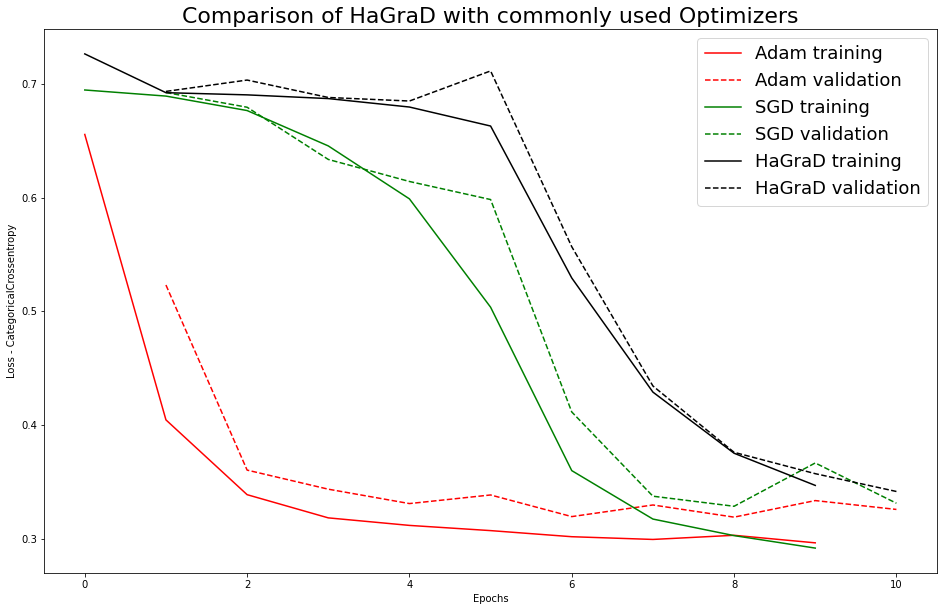

In [23]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Comparison of HaGraD with commonly used Optimizers", fontsize=22)
ax.plot(epochs_arr,     fit_adam.history['loss'],       "r-",  label="Adam training") 
ax.plot(epochs_arr_val, fit_adam.history['val_loss'],   "r--", label="Adam validation") 
ax.plot(epochs_arr,     fit_sgd.history['loss'],        "g-",  label="SGD training") 
ax.plot(epochs_arr_val, fit_sgd.history['val_loss'],    "g--", label="SGD validation") 
ax.plot(epochs_arr,     fit_hagrad.history['loss'],     "k-",  label="HaGraD training") 
ax.plot(epochs_arr_val, fit_hagrad.history['val_loss'], "k--", label="HaGraD validation") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss - CategoricalCrossentropy")
leg = ax.legend(frameon=True, fontsize=18)
plt.show()
plt.close()

---